# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Reds'

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [19]:
X_train_pad = np.pad(X_train, ((0,0), (1,1), (1,1), (0,0)), 'constant', constant_values=((0,0), (0,0), (0,0), (0,0)))
X_feat = np.zeros((49000,32,32,6))
for i in range(X_feat.shape[1]):
    for j in range(X_feat.shape[2]):
        X_feat[:,i,j,3:] = np.sqrt(np.sum(np.square(255-np.abs(X_train_pad[:,i:i+3,j:j+3,:] - X_train_pad[:,None,i+1,None,j+1,:])), axis=(1,2)))/(255*8) - 0.5
        X_feat[:,i,j,:3] = X_train[:,i,j]/255

In [21]:
X_feat.max()

1.0

In [22]:
X_val_pad = np.pad(X_val, ((0,0), (1,1), (1,1), (0,0)), 'constant', constant_values=((0,0), (0,0), (0,0), (0,0)))
X_feat_val = np.zeros((1000,32,32,6))
for i in range(X_feat_val.shape[1]):
    for j in range(X_feat_val.shape[2]):
        X_feat_val[:,i,j,3:] = np.sqrt(np.sum(np.square(255-np.abs(X_val_pad[:,i:i+3,j:j+3,:] - X_val_pad[:,None,i+1,None,j+1,:])), axis=(1,2)))/(255*8) - 0.5
        X_feat_val[:,i,j,:3] = X_val[:,i,j]/255

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [20]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

#learning_rates = [1e-9, 1e-8, 1e-7]
#regularization_strengths = [5e4, 5e5, 5e6]
n_params = 25
learning_rates = np.power(10, np.random.uniform(-4,-2, size=n_params))
regularization_strengths = np.power(10, np.random.uniform(-6,0, size=n_params))
params = [(learning_rates[i], regularization_strengths[i]) for i in range(n_params)]

#results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for rate, reg in params:
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=rate, reg=reg,
                num_iters=1500, verbose=False) 
    y_train_label = svm.predict(X_train_feats)
    training_accuracy = np.mean(y_train == y_train_label)
    y_val_label = svm.predict(X_val_feats)
    validation_accuracy = np.mean(y_val == y_val_label)
    results[(rate,reg)] = (training_accuracy, validation_accuracy)
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.141591e-09 reg 4.387015e+00 train accuracy: 0.123265 val accuracy: 0.118000
lr 3.842105e-09 reg 3.574410e+00 train accuracy: 0.122796 val accuracy: 0.130000
lr 7.893513e-09 reg 2.325542e+00 train accuracy: 0.105306 val accuracy: 0.127000
lr 1.239139e-08 reg 4.230930e-03 train accuracy: 0.100816 val accuracy: 0.101000
lr 8.443846e-08 reg 1.659950e-04 train accuracy: 0.131367 val accuracy: 0.137000
lr 1.323657e-07 reg 3.980079e+04 train accuracy: 0.414102 val accuracy: 0.425000
lr 1.718597e-07 reg 1.927776e-04 train accuracy: 0.125449 val accuracy: 0.121000
lr 1.950294e-07 reg 1.170203e+02 train accuracy: 0.142184 val accuracy: 0.126000
lr 5.988085e-07 reg 1.971714e+00 train accuracy: 0.192755 val accuracy: 0.223000
lr 6.312027e-07 reg 9.714174e+03 train accuracy: 0.417612 val accuracy: 0.412000
lr 1.166307e-06 reg 3.160897e+05 train accuracy: 0.339592 val accuracy: 0.337000
lr 1.418015e-06 reg 2.975835e-04 train accuracy: 0.282714 val accuracy: 0.256000
lr 1.582718e-06 reg 1.148786

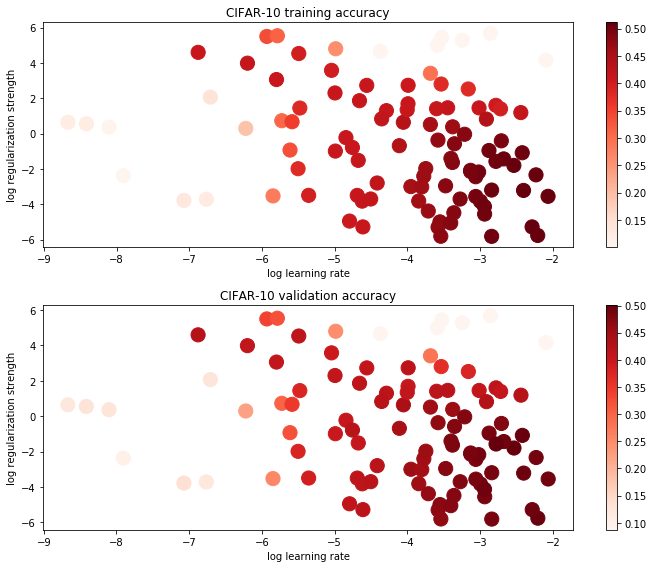

In [21]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 200
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.tight_layout() # tight layout

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.tight_layout() # tight layout
plt.show()

In [22]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.493


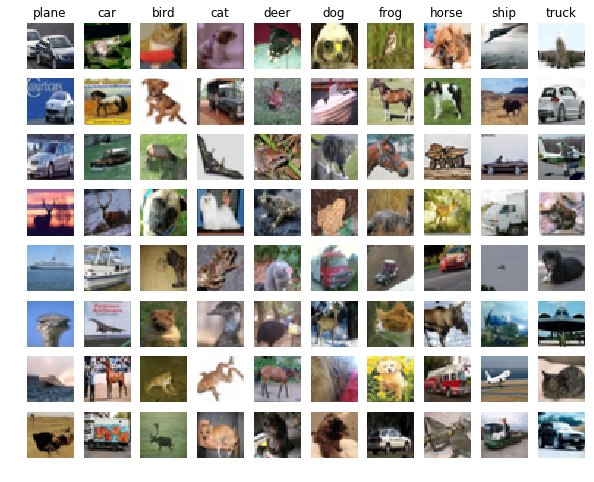

In [23]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [24]:
print(X_train_feats.shape)

(49000, 155)


In [52]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_size = X_train_feats.shape[1]
num_classes = 10

#best_net = None
#best_val = -1

n_params = 25
hidden_layer_sizes = np.random.randint(80, 120, size=n_params)
regularization_strengths = np.power(10, np.random.uniform(-12,-2, size=n_params))
learning_rates = np.power(10, np.random.uniform(-0.5,0.5, size=n_params))
decay_rates = np.random.uniform(0.75, 0.95, size=n_params)
params = [(hidden_layer_sizes[i], regularization_strengths[i], learning_rates[i], decay_rates[i])
          for i in range(n_params)]
#results = {}

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
for hidden_size, reg, rate, decay_rate in params:
    net = TwoLayerNet(input_size, hidden_size, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1225, batch_size=200,
            learning_rate=rate, learning_rate_decay=decay_rate,
            reg=reg, verbose=False)
    y_train_label = net.predict(X_train_feats)
    training_accuracy = np.mean(y_train == y_train_label)
    val_accuracy = stats['val_acc_history'][-1]
    results[(hidden_size,reg,rate,decay_rate)] = (training_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
        best_stats = stats
    print('hidden %d lr %e dr %f reg %e train accuracy: %f val accuracy: %f' % (
                hidden_size, rate, decay_rate, reg, training_accuracy, val_accuracy))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

print('best validation accuracy achieved during cross-validation: %f' % best_val)

C:\Users\yerdo\Anaconda3\envs\cs231n\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\yerdo\Documents\python\cs231n\assignment1\cs231n\classifiers\neural_net.py:102: RuntimeWarning: invalid value encountered in subtract
  scores -= np.amax(scores, axis=1, keepdims=True)
C:\Users\yerdo\Documents\python\cs231n\assignment1\cs231n\classifiers\neural_net.py:110: RuntimeWarning: overflow encountered in multiply
  loss += reg*(np.sum(W1*W1) + np.sum(W2*W2))
C:\Users\yerdo\Documents\python\cs231n\assignment1\cs231n\classifiers\neural_net.py:82: RuntimeWarning: invalid value encountered in maximum
  relu_layer = np.maximum(0, hidden_layer)
C:\Users\yerdo\Anaconda3\envs\cs231n\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\yerdo\Documents\python\cs231n\assignment1\cs231n\classifiers\neural

hidden 119 lr 5.035102e+01 dr 0.912759 reg 3.569101e-11 train accuracy: 0.100265 val accuracy: 0.087000
hidden 116 lr 4.668484e+00 dr 0.754780 reg 9.883532e-08 train accuracy: 0.638224 val accuracy: 0.525000
hidden 118 lr 7.412782e+00 dr 0.775263 reg 5.174711e-12 train accuracy: 0.123327 val accuracy: 0.114000


C:\Users\yerdo\Documents\python\cs231n\assignment1\cs231n\classifiers\neural_net.py:102: RuntimeWarning: overflow encountered in subtract
  scores -= np.amax(scores, axis=1, keepdims=True)


hidden 119 lr 3.175845e+01 dr 0.798449 reg 2.991100e-06 train accuracy: 0.100265 val accuracy: 0.087000
hidden 87 lr 3.848428e+01 dr 0.902949 reg 3.271084e-08 train accuracy: 0.100265 val accuracy: 0.087000
hidden 99 lr 8.704301e+00 dr 0.922537 reg 4.145244e-12 train accuracy: 0.100265 val accuracy: 0.087000
hidden 106 lr 3.332035e-01 dr 0.786200 reg 5.485047e-09 train accuracy: 0.570102 val accuracy: 0.531000
hidden 97 lr 2.737932e+01 dr 0.751414 reg 3.406976e-06 train accuracy: 0.100265 val accuracy: 0.087000
hidden 104 lr 5.325906e+00 dr 0.947305 reg 4.423546e-03 train accuracy: 0.100449 val accuracy: 0.098000
hidden 109 lr 1.817355e+01 dr 0.816722 reg 3.066196e-10 train accuracy: 0.100265 val accuracy: 0.087000
hidden 88 lr 1.107517e+00 dr 0.880364 reg 8.703309e-10 train accuracy: 0.633735 val accuracy: 0.544000
hidden 93 lr 5.800968e+01 dr 0.813317 reg 9.318275e-10 train accuracy: 0.100265 val accuracy: 0.087000
hidden 81 lr 2.793739e+00 dr 0.893394 reg 2.645320e-04 train accuracy

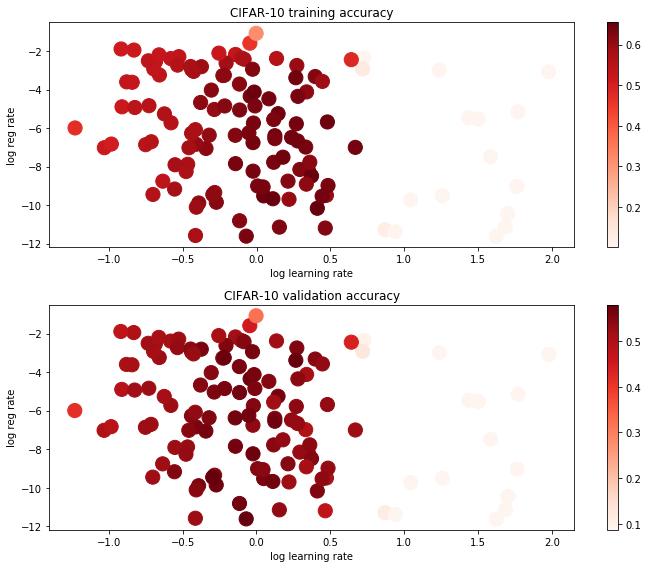

In [53]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[2]) for x in results] # rate
y_scatter = [math.log10(x[1]) for x in results] # reg

# plot training accuracy
marker_size = 200
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log reg rate')
plt.title('CIFAR-10 training accuracy')
plt.tight_layout() # tight layout

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log reg rate')
plt.title('CIFAR-10 validation accuracy')
plt.tight_layout() # tight layout
plt.show()

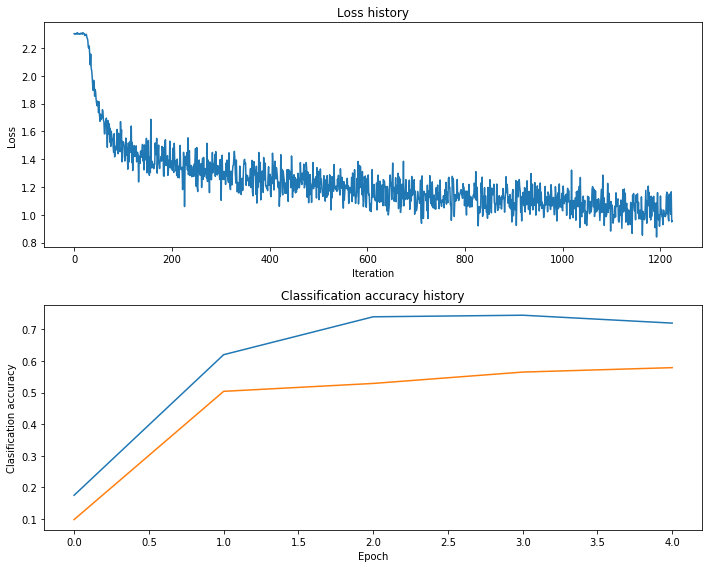

In [50]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout() # tight layout

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.tight_layout() # tight layout
plt.show()

In [51]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.55


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!